In [1]:
## import librerie

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## 
import utils as ut


## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3], ## colonne con significato noto
    names=["unixtime", "latitudine", "longitudine", "altitudine"] ## 
    )

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False]


gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")## conversione per calcoli distanza

time_start = df1['unixtime'][0]

In [2]:
## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = gdf['unixtime'].diff()
    
    return gdf


In [3]:
def aggiungi_velocita(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift())  # shift: prende punto successivo
    
    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['altitudine'].diff())**2
    )
    
    # calcola la velocità: spazio / tempo
    gdf['velocita'] = gdf['distanza_reale'] / gdf['unixtime'].diff()  # diff: calcola differenza con precedente
    
    gdf['velocita'] = gdf['velocita'].fillna(0)
    gdf['distanza_reale'] = gdf['distanza_reale'].fillna(0)
    gdf['distanza_orizzontale'] = gdf['distanza_orizzontale'].fillna(0)
    
    return gdf


In [4]:
def aggiungi_accelerazione(gdf):

    # Calcolo della variazione di velocità
    gdf['delta_velocita'] = gdf['velocita'].diff()

    ## accelerazione = Dv/Dt
    gdf['accelerazione'] = gdf['delta_velocita'] / gdf['delta_tempo']

    gdf['accelerazione'] = gdf['accelerazione'].fillna(0) 
    gdf.loc[gdf['delta_tempo'] == 0, 'accelerazione'] = 0  ## Evita divisioni per zero !!
    gdf.drop(columns=["delta_velocita"], inplace=True)


    return gdf


In [5]:
def geo_DBSCAN(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp
    gdf['norm_lat'] = gdf.geometry.y  # Latitudine
    gdf['norm_long'] = gdf.geometry.x  # Longitudine
    gdf['norm_alt'] = gdf['altitudine']  # Altitudine

    # Prepara le feature per la normalizzazione
    features = gdf[['norm_lat', 'norm_long', 'norm_alt']].to_numpy()

    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)

    # Applica DBSCAN sui dati normalizzati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster', 'norm_lat', 'norm_long', 'norm_alt']).reset_index(drop=True)



    return gdf_filtrato


In [6]:
def speed_DBSCAN(gdf, eps, min_samples):
    # Seleziona i dati da analizzare con DBSCAN
    features = gdf[['velocita']].to_numpy()

    # Applica DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster']).reset_index(drop=True)

    return gdf_filtrato



In [7]:
def acceleration_DBSCAN(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp
    gdf['norm_unixtime'] = gdf['unixtime']
    gdf['norm_acc'] = gdf['accelerazione']

    # Prepara le feature per la normalizzazione
    features = gdf[['norm_unixtime', 'norm_acc']].to_numpy()

    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)

    # Applica DBSCAN sui dati normalizzati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].reset_index(drop=True)


    return gdf_filtrato



In [8]:
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >=8900) & (gdf1['unixtime'] - time_start<= 9100)].reset_index(drop=True)
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 15400) & (gdf1['unixtime'] - time_start<= 15700)].reset_index(drop=True)
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 9200) & (gdf1['unixtime'] - time_start<= 9800)].reset_index(drop=True)
gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 23000) & (gdf1['unixtime'] - time_start<= 23500)].reset_index(drop=True)

while True:
    # Calcola le colonne necessarie
    gdf1 = aggiungi_delta_tempo(gdf1)
    gdf1 = aggiungi_velocita(gdf1)
    gdf1 = aggiungi_accelerazione(gdf1)

    # Controlla se ci sono accelerazioni fuori dall'intervallo [-2.5, 2.5]
    mask = (gdf1['accelerazione'] > 10) 

    # Se tutte le accelerazioni sono valide, esci dal ciclo
    if not mask.any():
        break

    # Altrimenti elimina le righe con accelerazioni fuori dall'intervallo
    gdf1 = gdf1[~mask].reset_index(drop=True)

while True:
    # Calcola le colonne necessarie
    gdf1 = aggiungi_delta_tempo(gdf1)
    gdf1 = aggiungi_velocita(gdf1)
    gdf1 = aggiungi_accelerazione(gdf1)

    # Controlla se ci sono accelerazioni fuori dall'intervallo [-2.5, 2.5]
    mask = (gdf1['accelerazione'] < -10) 

    # Se tutte le accelerazioni sono valide, esci dal ciclo
    if not mask.any():
        break

    # Altrimenti elimina le righe con accelerazioni fuori dall'intervallo
    gdf1 = gdf1[~mask].reset_index(drop=True)





gdf1.to_csv('data/gdf1.csv', index=False)

gdf1["delta_tempo"].describe()

#print(gdf1.head())

count    62.000000
mean      7.849613
std      11.897945
min       0.994000
25%       1.997000
50%       3.003000
75%       8.999250
max      66.998000
Name: delta_tempo, dtype: float64

In [9]:
#gdf1=geo_DBSCAN(gdf1, eps=0.5, min_samples=5)
#gdf1=speed_DBSCAN(gdf1, eps=0.4, min_samples=5)
#gdf1=acceleration_DBSCAN(gdf1, eps=0.07, min_samples=10)
gdf1.to_csv('data/gdf1.csv', index=False)

gdf1["latitudine"].describe()

count    63.000000
mean     46.521573
std       0.000118
min      46.521367
25%      46.521469
50%      46.521596
75%      46.521695
max      46.521715
Name: latitudine, dtype: float64

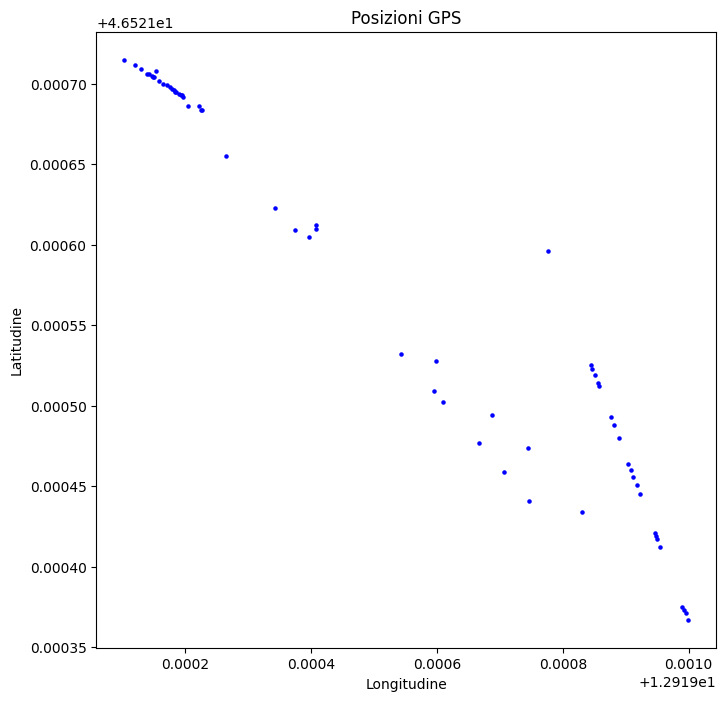

In [10]:
import matplotlib.pyplot as plt

# Esempio di dati (usa i tuoi dati)
latitudini = gdf1['latitudine']
longitudini = gdf1['longitudine']

# Crea il grafico con uno sfondo bianco
plt.figure(figsize=(8, 8))
plt.scatter(longitudini, latitudini, color='blue', marker='o', s=5)  # s è la dimensione dei punti
plt.title("Posizioni GPS")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
#plt.ylim(46.520, 46.525)

# Impostazioni per lo sfondo bianco
plt.gca().set_facecolor('white')

plt.show()

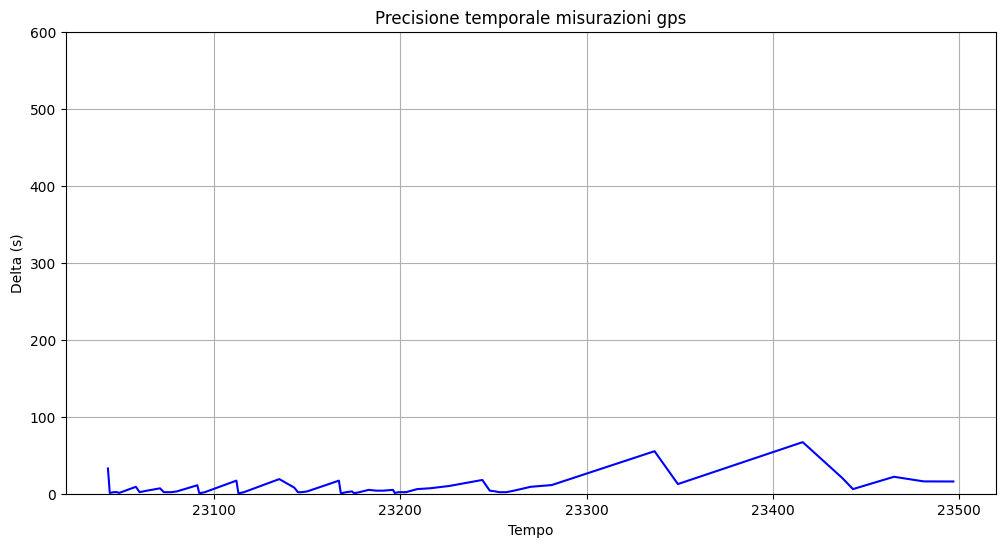

count    62.000000
mean      7.849613
std      11.897945
min       0.994000
25%       1.997000
50%       3.003000
75%       8.999250
max      66.998000
Name: delta_tempo, dtype: float64

In [11]:
## Delta tempo
plt.figure(figsize=(12, 6))
plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['delta_tempo'], 
    label='Intervallo di tempo tra misurazioni', 
    color='blue'
    )

plt.xlabel('Tempo')
plt.ylabel('Delta (s)')
plt.title('Precisione temporale misurazioni gps')
plt.grid(True)
plt.ylim(0, 600)  ## max 600 secondi-> 10 minuti di pausa
#plt.xlim(12000, 16500)

plt.show()

gdf1["delta_tempo"].describe()


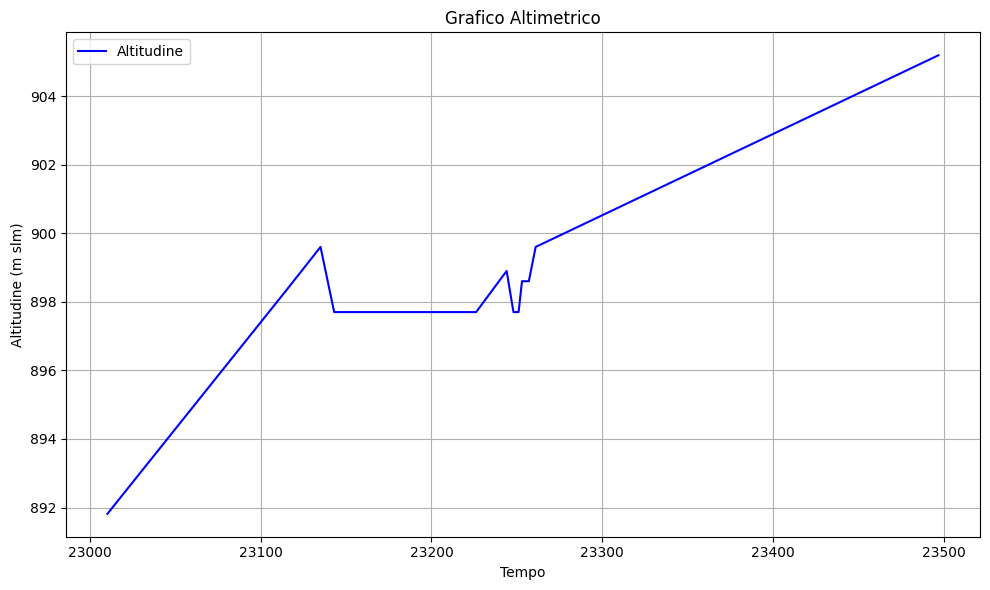

count     63.000000
mean     897.965560
std        2.692752
min      891.818195
25%      896.937922
50%      897.700012
75%      898.499969
max      905.189281
Name: altitudine, dtype: float64

In [12]:
## Altimetria della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')
plt.title('Grafico Altimetrico')
plt.grid(True)
plt.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()

gdf1["altitudine"].describe()


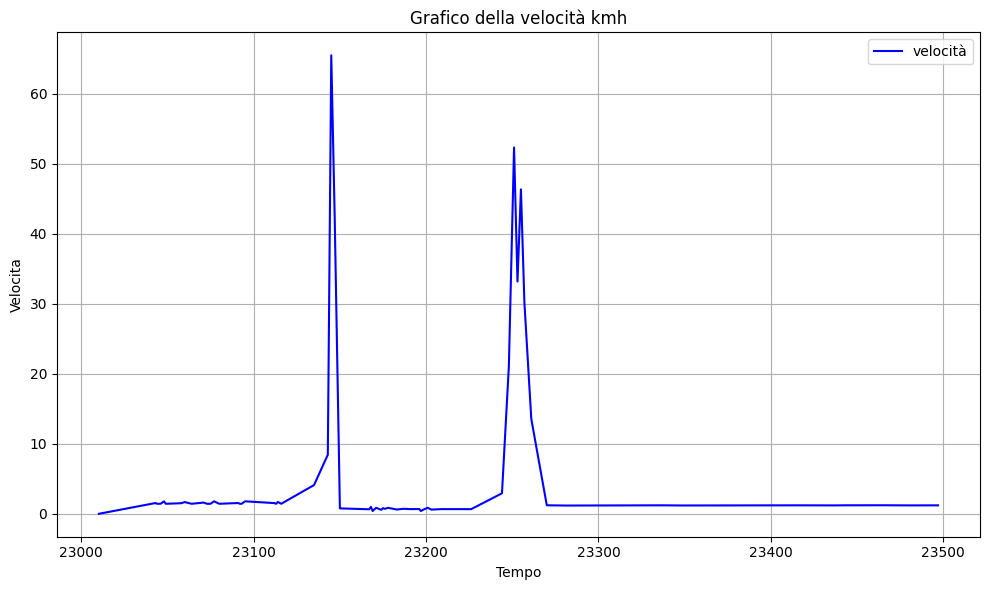

count    63.000000
mean      1.666057
std       3.783631
min       0.000000
25%       0.219222
50%       0.396115
75%       0.454666
max      18.191524
Name: velocita, dtype: float64

In [13]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['velocita'] * 3.6, 
    label='velocità', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Velocita')
plt.title('Grafico della velocità kmh')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

gdf1["velocita"].describe()


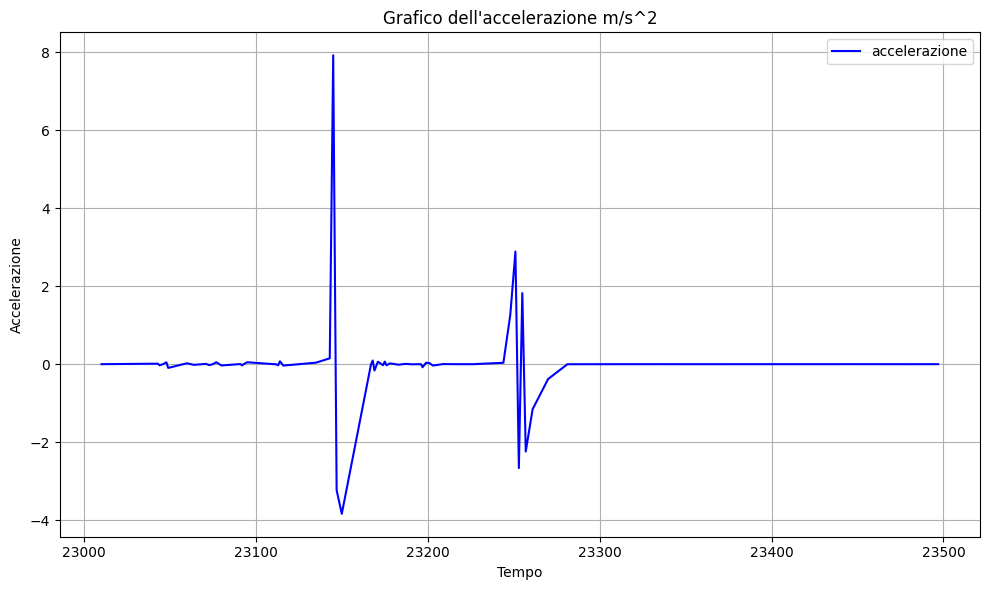

count    63.000000
mean      0.008679
std       1.361632
min      -3.838021
25%      -0.027170
50%       0.000070
75%       0.024415
max       7.924573
Name: accelerazione, dtype: float64

In [14]:
## Accelerazione della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['accelerazione'], 
    label='accelerazione', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Accelerazione')
plt.title('Grafico dell\'accelerazione m/s^2')
plt.grid(True)
plt.legend()
#plt.ylim(-4,4)

# Mostrare il grafico
plt.tight_layout()
plt.show()

gdf1["accelerazione"].describe()
